In [1]:
import csv

# read single data
def load_single_file(file_name):
    csv_reader = csv.reader(open(file_name,encoding='utf-8'))
    idx = 0
    header = []
    date_hour_location_to_gas_to_value_map = {}
    for row in csv_reader:
        if idx == 0:
            header = row
        else:
            if len(row) < 3:
                continue
            date=row[0]
            hour=row[1]
            data_type=row[2]
            if data_type.endswith("_24h"):
                continue
            for j in range(3, len(row)):
                location=header[j]
                date_hour_location = date+"_"+hour+"_"+location
                if not date_hour_location in date_hour_location_to_gas_to_value_map:
                    date_hour_location_to_gas_to_value_map[date_hour_location] = {}
                date_hour_location_to_gas_to_value_map[date_hour_location][data_type] = row[j]
        idx+=1
    # print(date_hour_location_to_gas_to_value_map)
    return date_hour_location_to_gas_to_value_map
    
    

# load_single_file("beijing_20140101-20141231/beijing_all_20141231.csv")
# load_single_file("beijing_20140101-20141231/beijing_extra_20141231.csv")

    

In [2]:
# load all data into X, y
import os
import numpy as np
def load_all_data():
    datas={}
    data_root_path="./data/"
    for subpath in os.listdir(data_root_path):
        print(subpath)
        for file in os.listdir(os.path.join(data_root_path, subpath)):
            if not file.endswith(".csv"):
                continue
            file_name = os.path.join(data_root_path, subpath, file)
            single_data=load_single_file(file_name)
            for date_hour_location, gas_value_map in single_data.items():
                if not date_hour_location in datas:
                    datas[date_hour_location] = gas_value_map
                else:
                    for gas, value in gas_value_map.items():
                        datas[date_hour_location][gas] = value
    
    X = []
    Y = []
    gas_types = ["PM2.5", "PM10", "SO2", "NO2", "O3", "CO"]
    for data_hour_location, gas_value_map in datas.items():
        remove_data = False
        for gas in gas_types:
            if gas not in gas_value_map or len(gas_value_map[gas]) == 0:
                remove_data=True
        if "AQI" not in gas_value_map or len(gas_value_map["AQI"])==0:
            remove_data=True
        if remove_data:
            continue
        X.append([])
        for gas in gas_types:
            X[-1].append(float(gas_value_map[gas]))
        heavy_polluted = 0
        if float(gas_value_map["AQI"])>200:
            heavy_polluted=1
        Y.append(heavy_polluted)
    return X,Y
            
            
X, y = load_all_data()
np.savetxt("X.txt", X)
np.savetxt("y.txt", y)

beijing_20140101-20141231
beijing_20150101-20151231
beijing_20160101-20161231
beijing_20170101-20171231
beijing_20180101-20181231
beijing_20190101-20191231
beijing_20200101-20201231
beijing_20210101-20211231
beijing_20220101-20221231
beijing_20230101-20231231
beijing_20240101-20241231
beijing_20250101-20250222


In [3]:
import numpy as np
original_X = np.loadtxt("X.txt")
y = np.loadtxt("y.txt")


In [4]:
# plot gas distribution, entropy, gini
print(original_X.shape,y.shape) 
import matplotlib.pyplot  as plt 

def split_data(data, bin_count=30,filtered_range=[0.1,0.9]):
    data=np.sort(data)
    l=len(data)
    data=data[int(l*filtered_range[0]):int(l*filtered_range[1])]
    min_val = np.min(data)
    max_val = np.max(data)
    bins = []
    bin_strs = []
    bin_heights=np.zeros(bin_count)
    stride = (max_val-min_val)/bin_count
    for i in range(bin_count):
        start=0
        end=0
        if i==bin_count-1:
            start=max_val-stride
            end=max_val
        else:
            start=min_val+i*stride
            end=min_val+(i+1)*stride
        bins.append([start,end])
        start_str=format(start, f".2f")
        end_str=format(end,f".2f")
        bin_strs.append(start_str+"-"+end_str)
    
    for val in data:
        for i in range(bin_count):
            if val>=bins[i][0] and val<bins[i][1]:
                bin_heights[i]+=1
                continue
                
    return bins, bin_strs, bin_heights

def get_entropy(labels):
    _, counts = np.unique(labels,  return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities  * np.log2(probabilities))

def get_gini(labels):
    _, counts = np.unique(labels,  return_counts=True)
    probabilities = counts / len(labels)
    return 1 - np.sum(probabilities**2) 

def compute_entropy_gini(data, labels, bins):
    entropys=np.zeros(len(bins))
    ginis=np.zeros(len(bins))
    
    sub_labels=[]
    for i in range(len(bins)):
        sub_labels.append([])
    
    for i in range(len(data)):
        for j in range(len(bins)):
            if data[i]>=bins[j][0] and data[i]<bins[j][1]:
                sub_labels[j].append(y[i])
                continue
    for i in range(len(bins)):
        entropys[i]=get_entropy(sub_labels[i])
        ginis[i]=get_gini(sub_labels[i])
        
    return entropys, ginis

def plot_data(data, labels, gas_type,bin_count=15,filtered_range=[0.1,0.9]):
    bins, groups, heights = split_data(data,bin_count,filtered_range=[0.1,0.9])
    entropys, ginis=compute_entropy_gini(data, labels, bins)
    print(groups,heights)
    print(entropys, ginis)
    fig, ax = plt.subplots(figsize=(25,10)) 
    plt.xticks(rotation= 45)
    plt.bar(groups,heights,label='distribution')
    ax.set_xlabel('Gas concentration')
    ax.set_ylabel('Hours')
    ax.set_title(gas_type+" Distribution")
    ax.set_xticklabels(groups) 
    
    ax2 = ax.twinx()   # 共享x轴，新建右侧y轴 
    ax2.plot(groups,  entropys, color='red', marker='o', label='entropy')  # 绘制曲线图
    ax2.plot(groups, ginis, color='yellow', marker='o', label='gini')
    ax2.set_ylabel('entropy/gini', color='blue')
    ax2.tick_params(axis='y',  labelcolor='red')
    plt.legend()
    plt.tight_layout() 
    plt.show()

gas_types=["PM2.5", "PM10", "SO2", "NO2", "O3", "CO"]
# for i in range(len(gas_types)):
#     plot_data(original_X[:,i],y, gas_types[i])




(2443652, 6) (2443652,)


['5.00-11.07', '11.07-17.13', '17.13-23.20', '23.20-29.27', '29.27-35.33', '35.33-41.40', '41.40-47.47', '47.47-53.53', '53.53-59.60', '59.60-65.67', '65.67-71.73', '71.73-77.80', '77.80-83.87', '83.87-89.93', '89.93-96.00'] [380682. 277086. 225828. 190962. 159268. 133494. 112404.  95664.  81056.
  68947.  59447.  51964.  45001.  38547.  33263.]
[0.02791692 0.04273905 0.03929533 0.0399477  0.045973   0.05429347
 0.06936398 0.08398896 0.09466605 0.09650203 0.10490215 0.11887296
 0.1380559  0.15549498 0.16713703] [0.00561672 0.00926069 0.00838687 0.00855122 0.01009494 0.01229852
 0.01648054 0.02074937 0.02398476 0.02455067 0.02717435 0.03165847
 0.03804645 0.04407136 0.04820291]


C:\Users\86178\AppData\Local\Temp\ipykernel_4088\1502277135.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups)


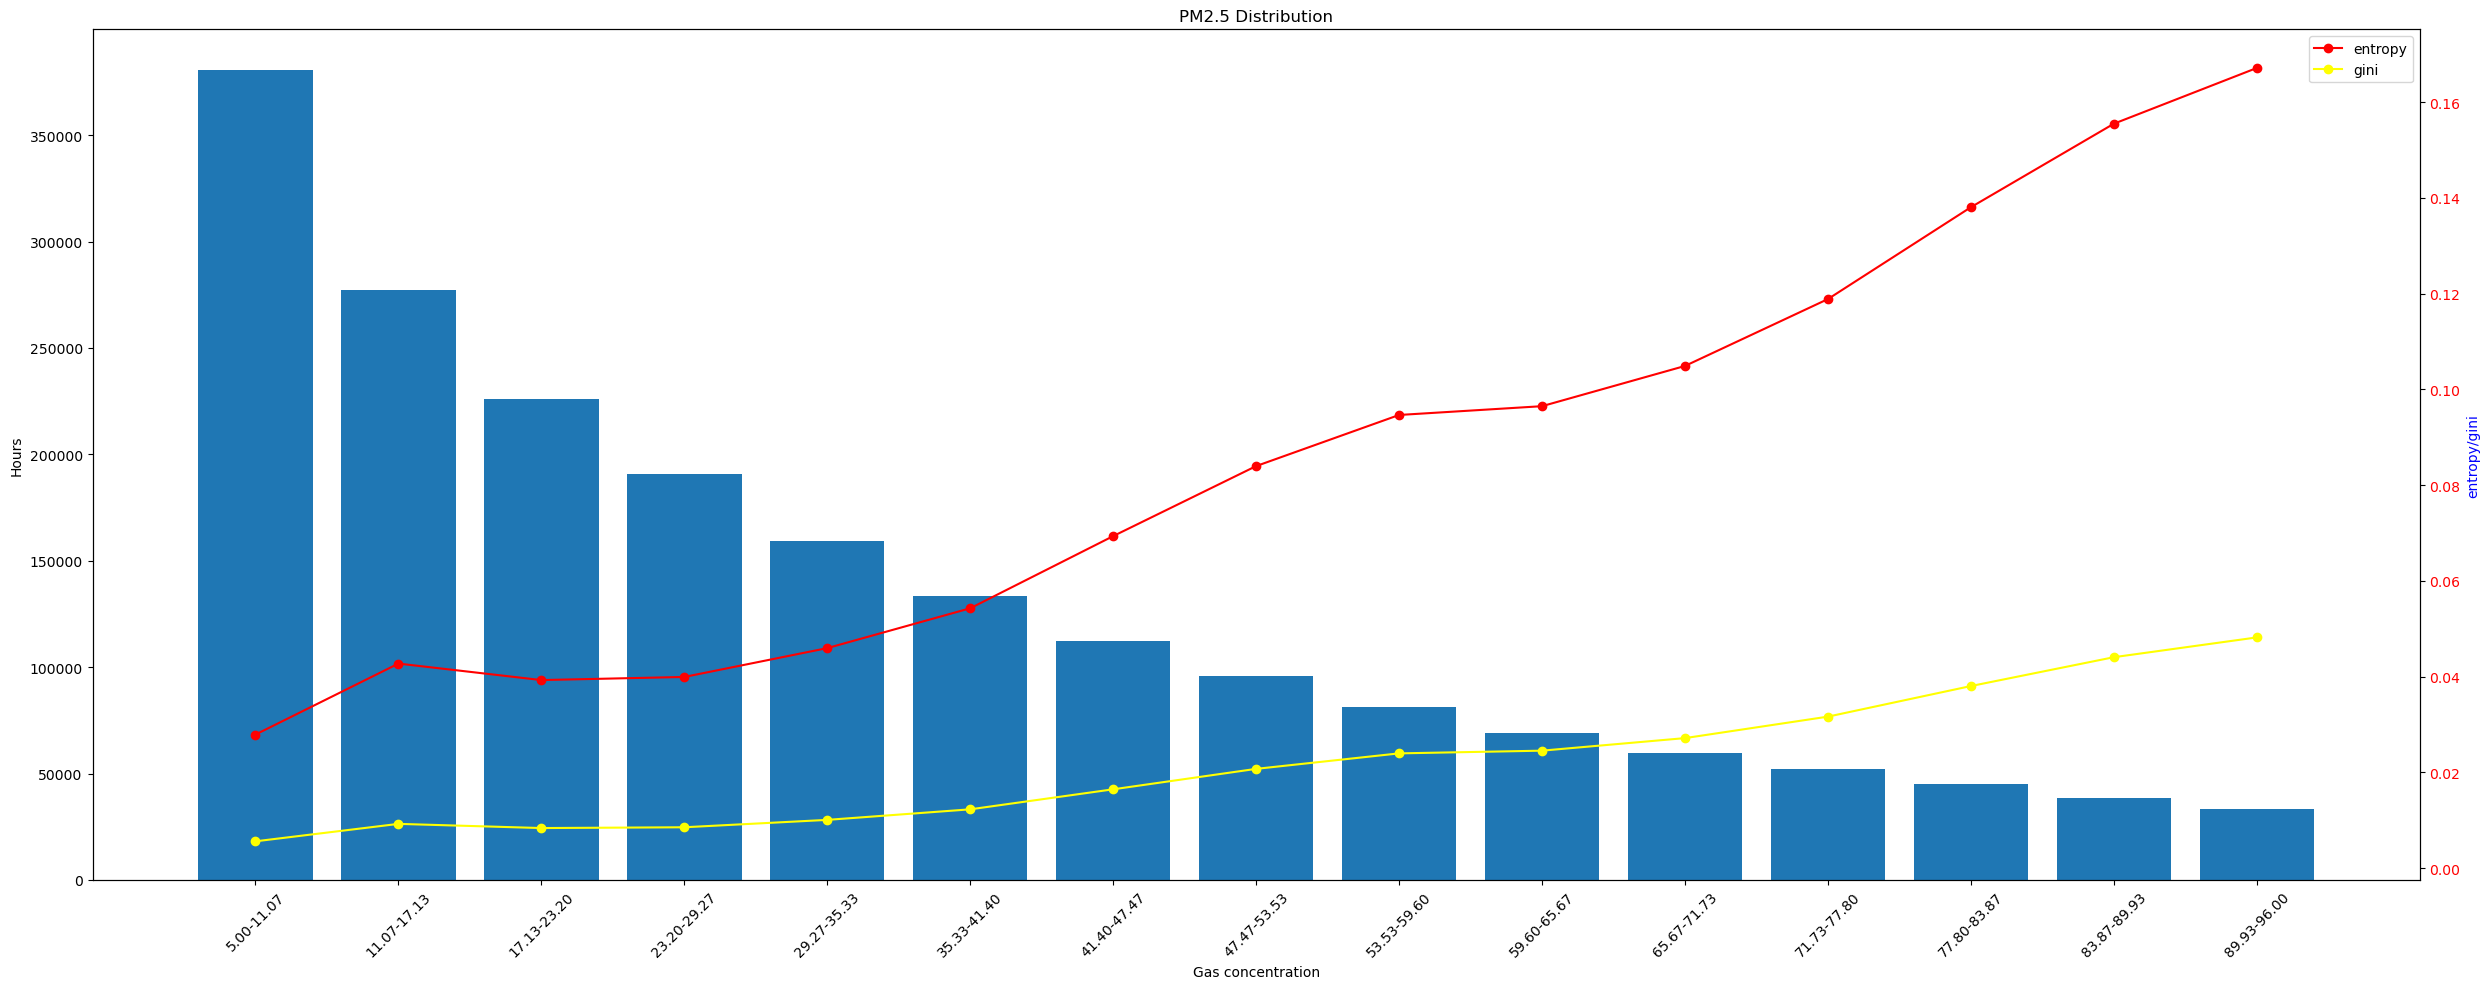

In [5]:
# PM2.5
plot_data(original_X[:,0],y, gas_types[0],bin_count=15)

['16.00-25.29', '25.29-34.59', '34.59-43.88', '43.88-53.17', '53.17-62.47', '62.47-71.76', '71.76-81.05', '81.05-90.35', '90.35-99.64', '99.64-108.93', '108.93-118.23', '118.23-127.52', '127.52-136.81', '136.81-146.11', '146.11-155.40'] [261501. 225237. 205955. 207627. 169940. 152840. 149195. 117130. 101347.
  85894.  79168.  60790.  52397.  48265.  37632.]
[0.02616276 0.02824237 0.02840823 0.02603871 0.02981753 0.03069095
 0.03510822 0.03887379 0.0433899  0.05055398 0.05961416 0.06946348
 0.08381835 0.09572614 0.14209056] [0.00520728 0.00569324 0.0057323  0.00517852 0.00606599 0.00627436
 0.00734572 0.00828097 0.00942754 0.01129829 0.01374815 0.01650891
 0.02069846 0.02431118 0.03942242]


C:\Users\86178\AppData\Local\Temp\ipykernel_4088\1502277135.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups)


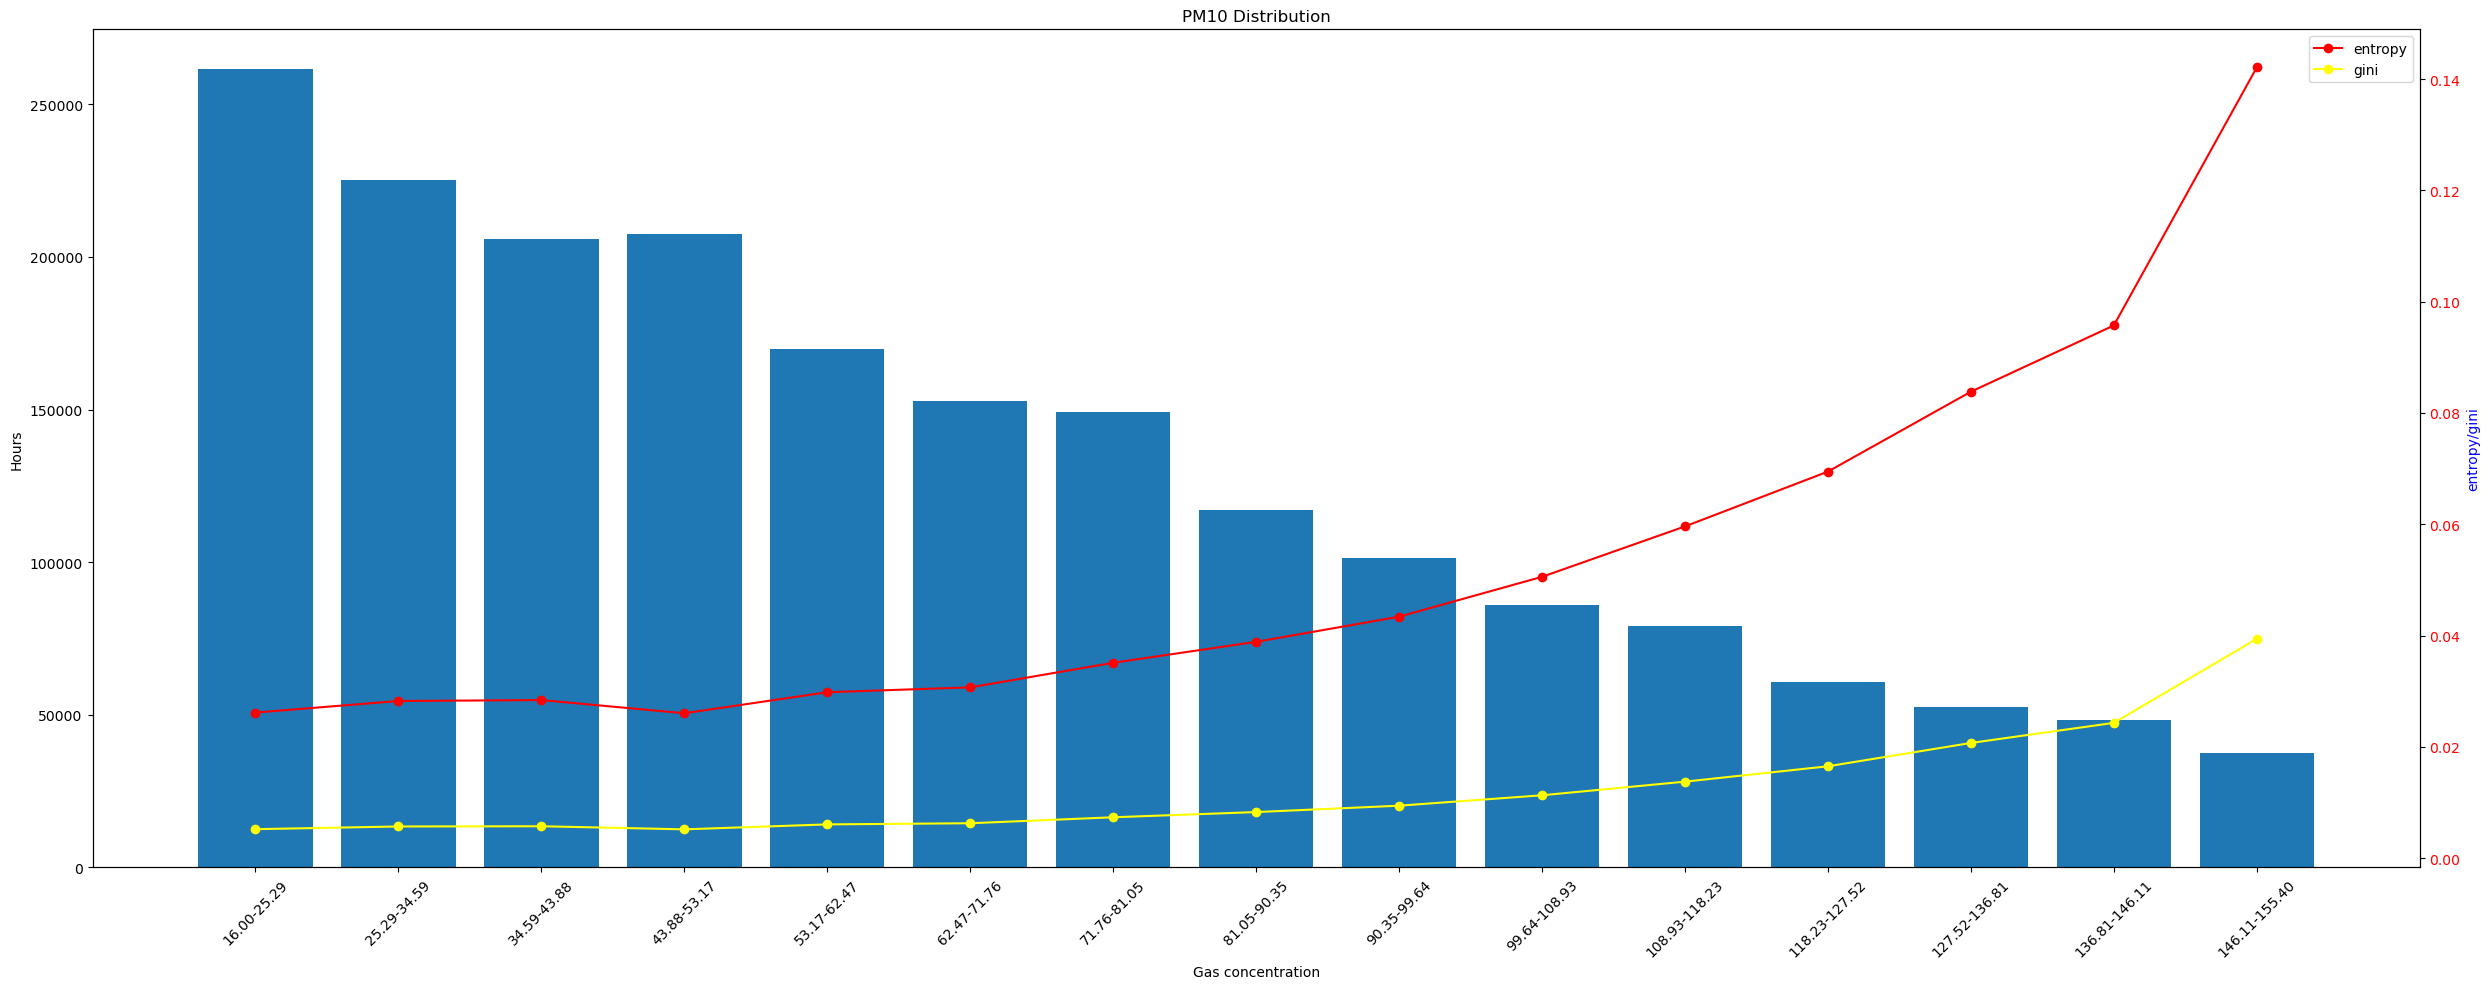

In [6]:
# PM10
plot_data(original_X[:,1],y, gas_types[1],bin_count=15)

['1.00-2.50', '2.50-4.00', '4.00-5.50', '5.50-7.00', '7.00-8.50', '8.50-10.00', '10.00-11.50', '11.50-13.00'] [551113. 787012. 269190.  89066. 113543.  45784.  61527.  28227.]
[0.10703146 0.10755697 0.16795848 0.21665372 0.24792842 0.28998605
 0.31158836 0.34891942] [0.02784822 0.02801506 0.04849763 0.06668688 0.07907023 0.09652399
 0.10582868 0.1224276 ]


C:\Users\86178\AppData\Local\Temp\ipykernel_4088\1502277135.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups)


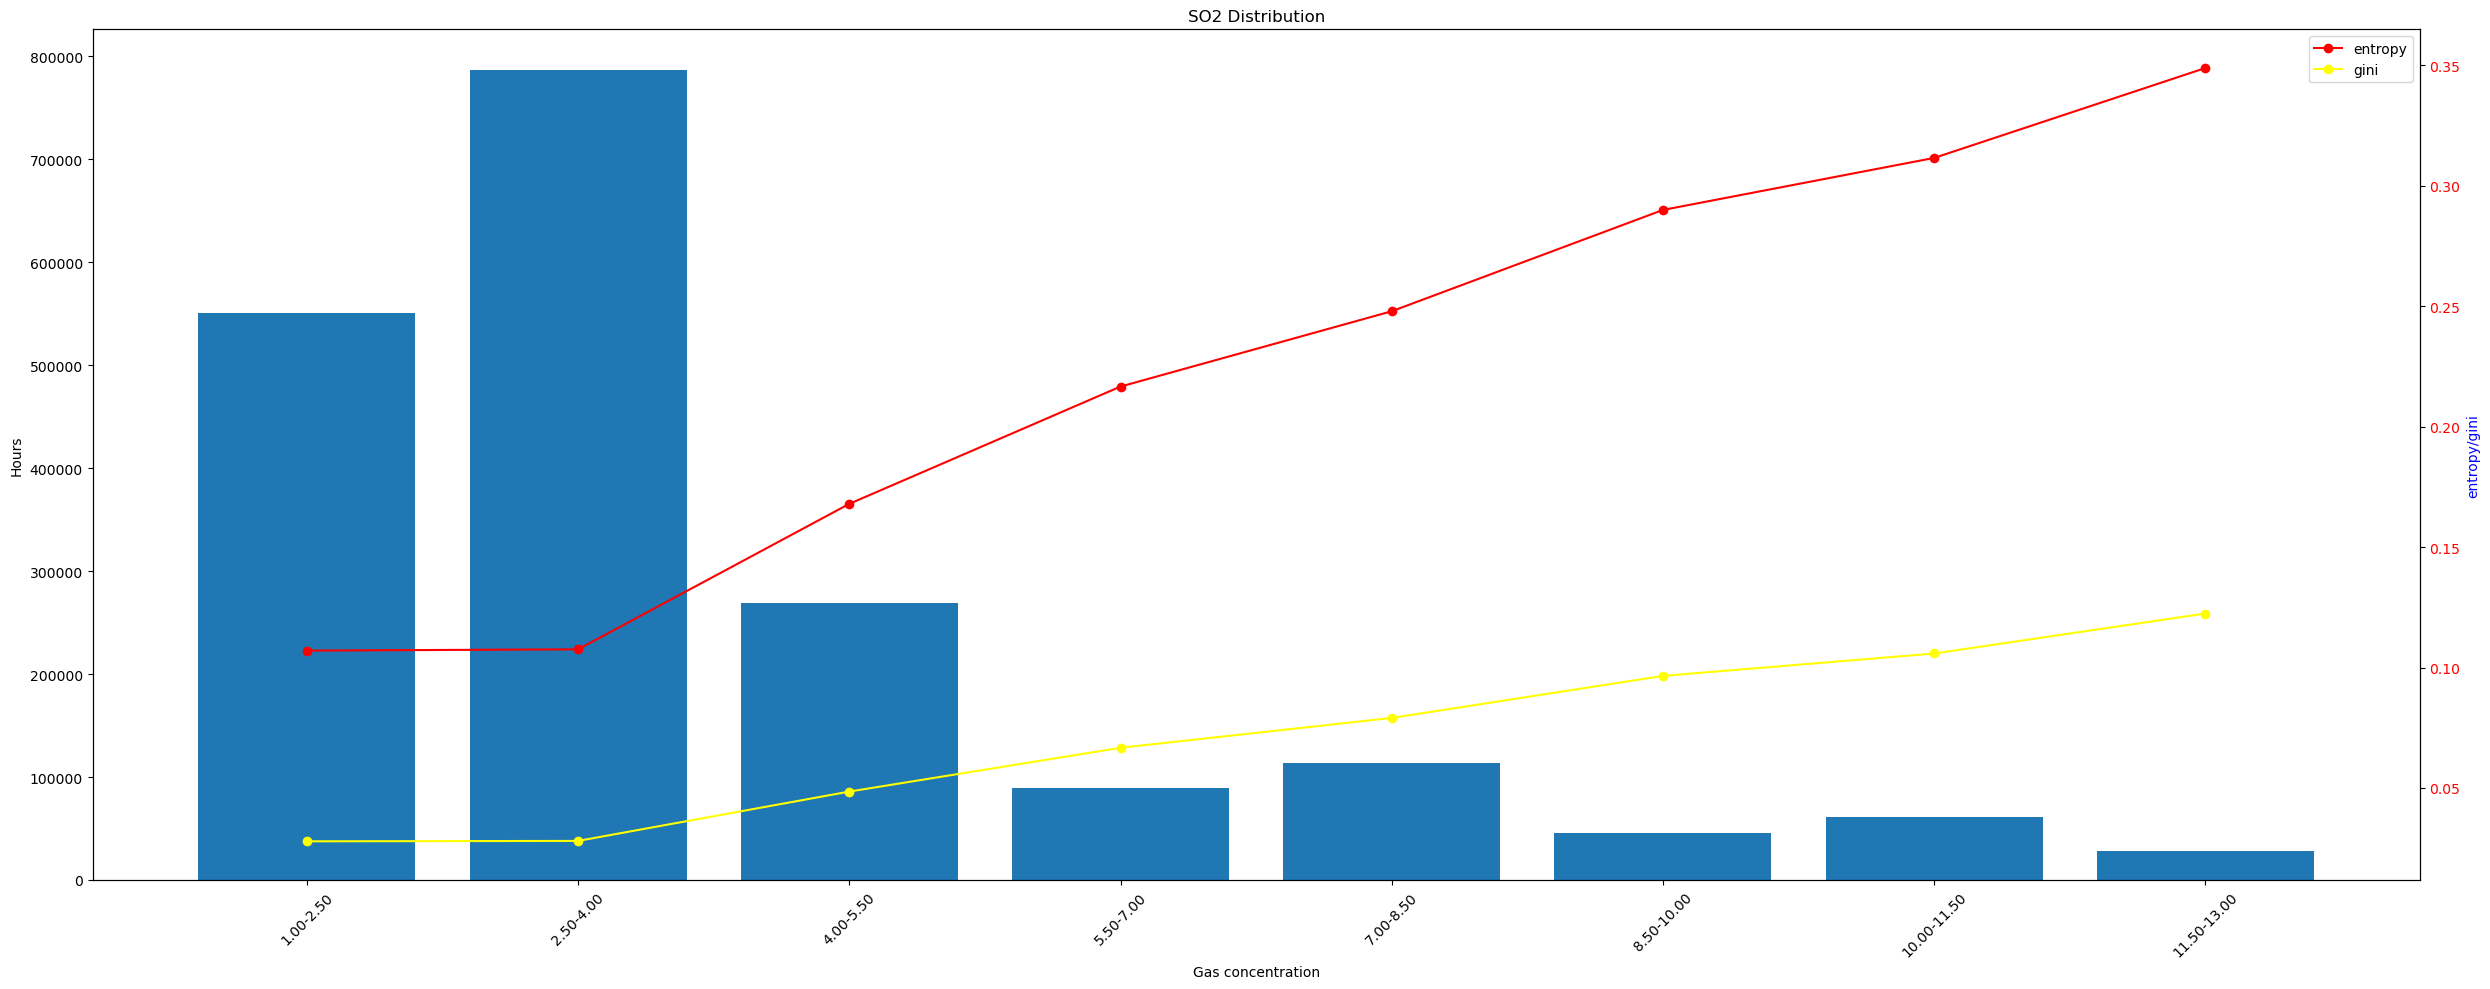

In [7]:
# SO2
plot_data(original_X[:,2],y, gas_types[2],bin_count=8)

['6.00-10.67', '10.67-15.33', '15.33-20.00', '20.00-24.67', '24.67-29.33', '29.33-34.00', '34.00-38.67', '38.67-43.33', '43.33-48.00', '48.00-52.67', '52.67-57.33', '57.33-62.00', '62.00-66.67', '66.67-71.33', '71.33-76.00'] [235037. 278886. 196952. 205506. 171181. 119567. 126775. 112275.  83825.
  94044.  86180.  64171.  70718.  62791.  45285.]
[0.10723332 0.07754605 0.07989915 0.0879651  0.10341041 0.1194383
 0.13512697 0.15135317 0.16214506 0.17932589 0.19645927 0.21423552
 0.23309309 0.25259237 0.31369626] [0.02791228 0.01884471 0.01953605 0.02194295 0.02670435 0.03184299
 0.0370545  0.04262235 0.04642088 0.05261869 0.05897627 0.0657515
 0.07313071 0.08096137 0.10674858]


C:\Users\86178\AppData\Local\Temp\ipykernel_4088\1502277135.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups)


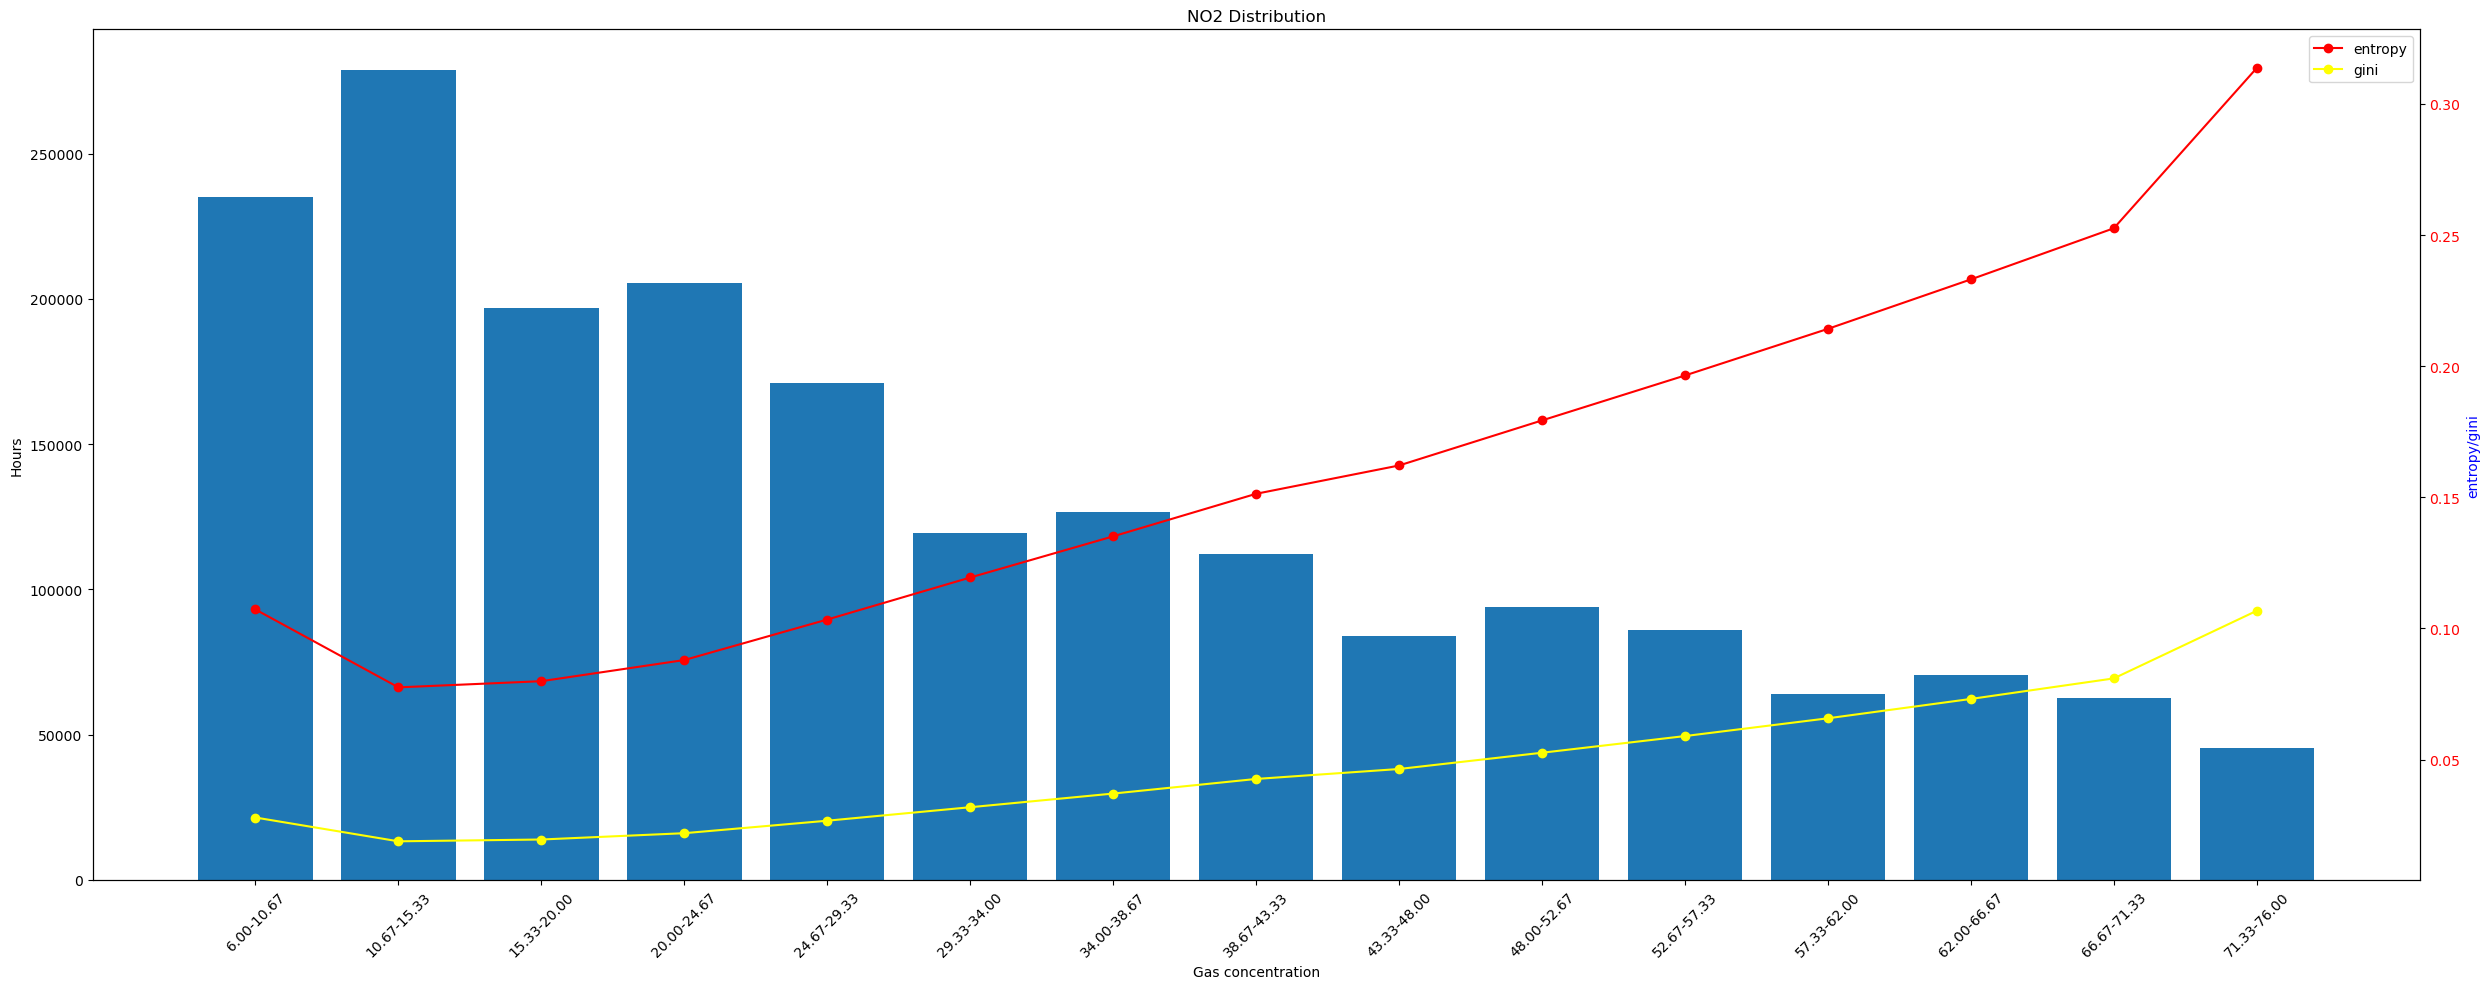

In [8]:
# NO2
plot_data(original_X[:,3],y, gas_types[3],bin_count=15)

['2.00-10.67', '10.67-19.33', '19.33-28.00', '28.00-36.67', '36.67-45.33', '45.33-54.00', '54.00-62.67', '62.67-71.33', '71.33-80.00', '80.00-88.67', '88.67-97.33', '97.33-106.00', '106.00-114.67', '114.67-123.33', '123.33-132.00'] [215781. 150137. 131413. 155710. 173273. 175298. 207525. 185218. 135960.
 119632.  93831.  65989.  58522.  48062.  37267.]
[0.42318305 0.26727939 0.18780855 0.15628668 0.13679907 0.13793624
 0.13672032 0.15954231 0.18924603 0.19631819 0.15483857 0.12479606
 0.1186188  0.1111113  0.10697499] [0.15730881 0.08698986 0.05574469 0.04434959 0.03762008 0.03800581
 0.0375934  0.04549796 0.05627865 0.05892322 0.04384098 0.03360312
 0.0315756  0.02914909 0.0278303 ]


C:\Users\86178\AppData\Local\Temp\ipykernel_4088\1502277135.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups)


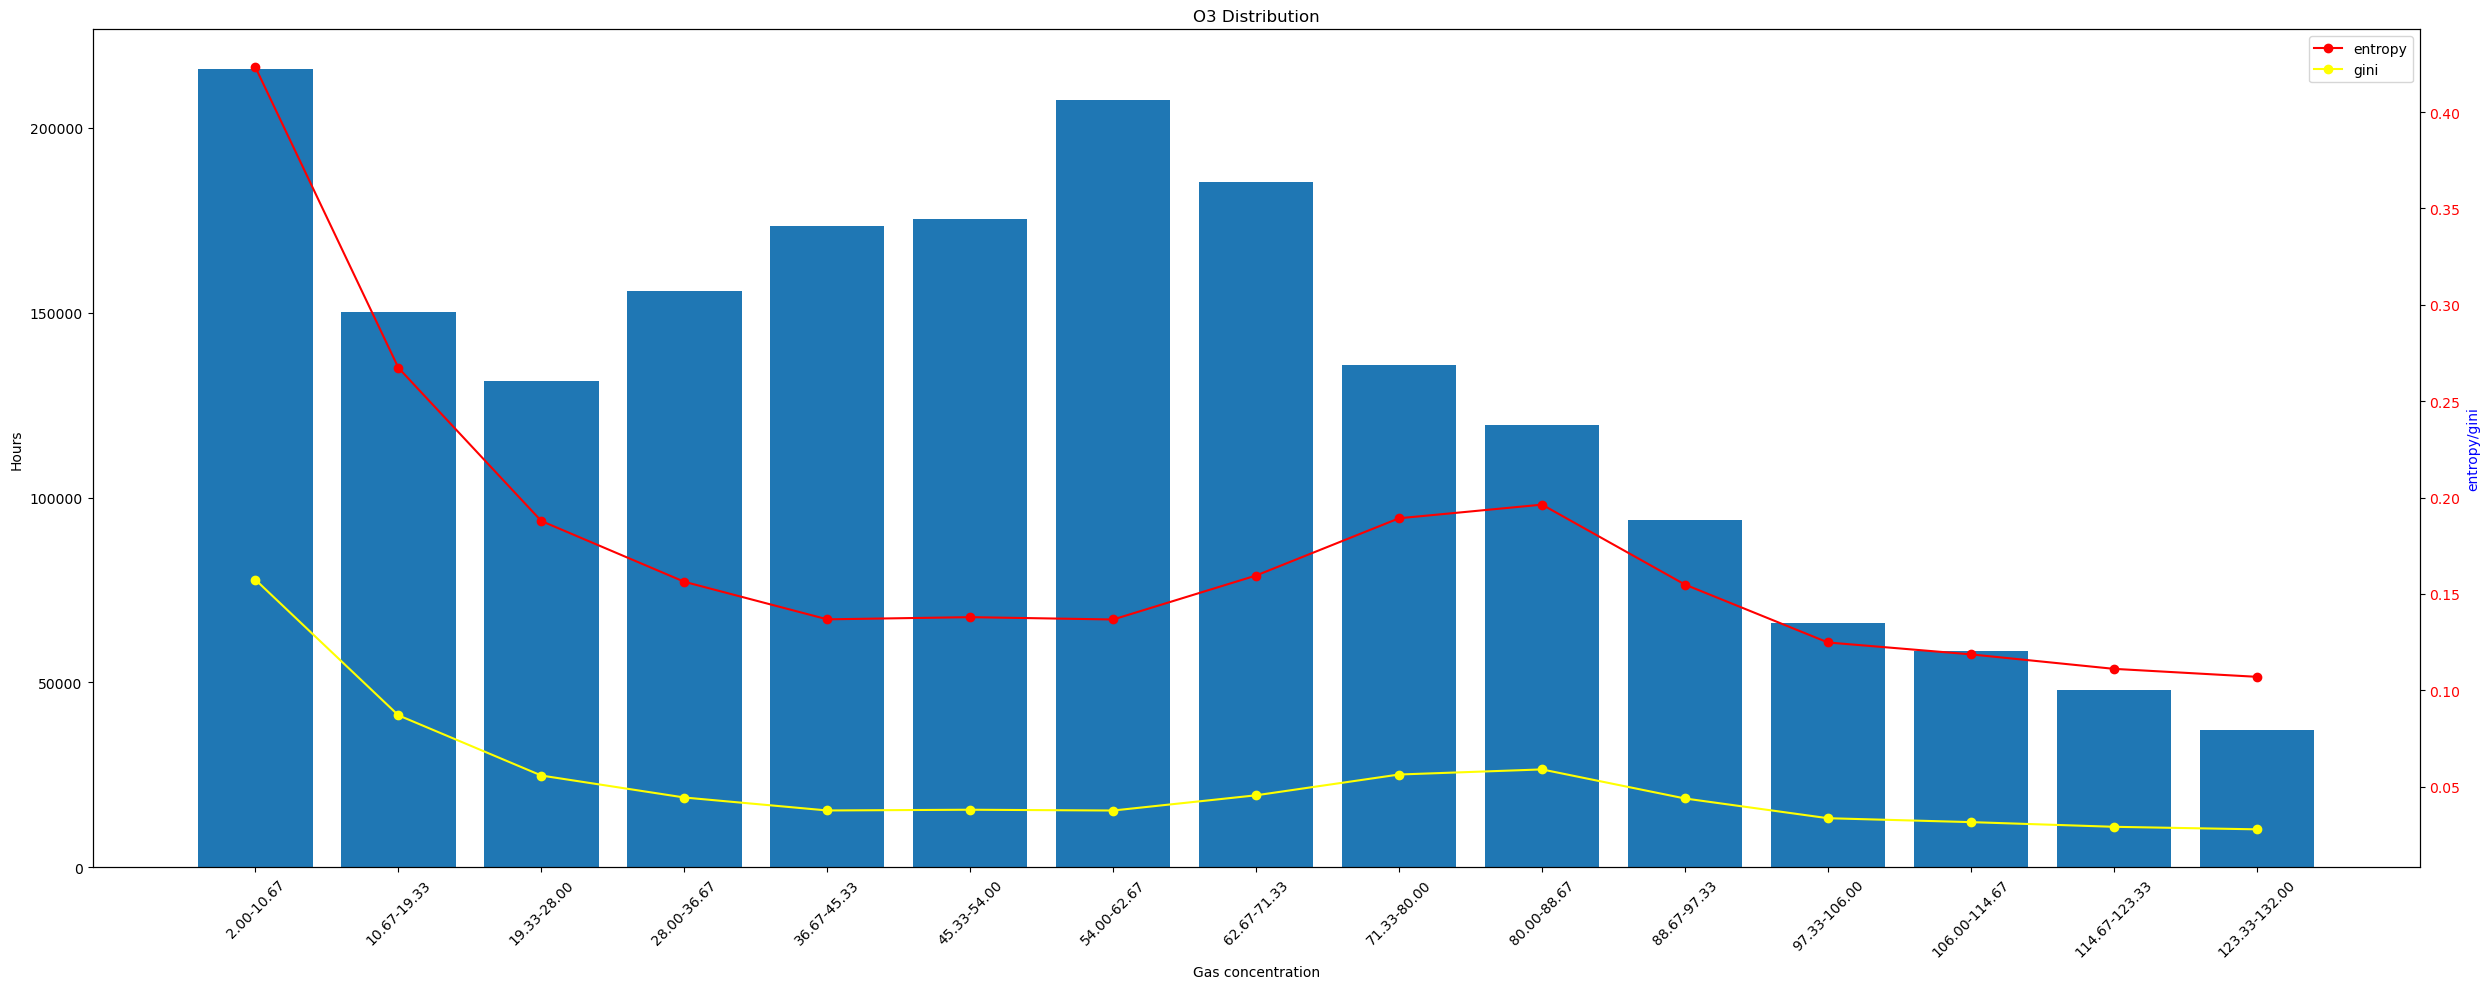

In [9]:
# O3
plot_data(original_X[:,4],y, gas_types[4],bin_count=15)

['0.20-0.31', '0.31-0.42', '0.42-0.53', '0.53-0.64', '0.64-0.75', '0.75-0.86', '0.86-0.97', '0.97-1.08', '1.08-1.19', '1.19-1.30'] [448330. 297523. 277649. 240653. 193236. 147208. 113365.  93876.  68243.
  52372.]
[0.11137133 0.07228834 0.06151932 0.05686567 0.05502581 0.06386196
 0.09904767 0.17565264 0.19948903 0.26663536] [0.02923243 0.0173183  0.0142745  0.01299552 0.01249623 0.01492684
 0.02533984 0.05127841 0.06011833 0.0867232 ]


C:\Users\86178\AppData\Local\Temp\ipykernel_4088\1502277135.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups)


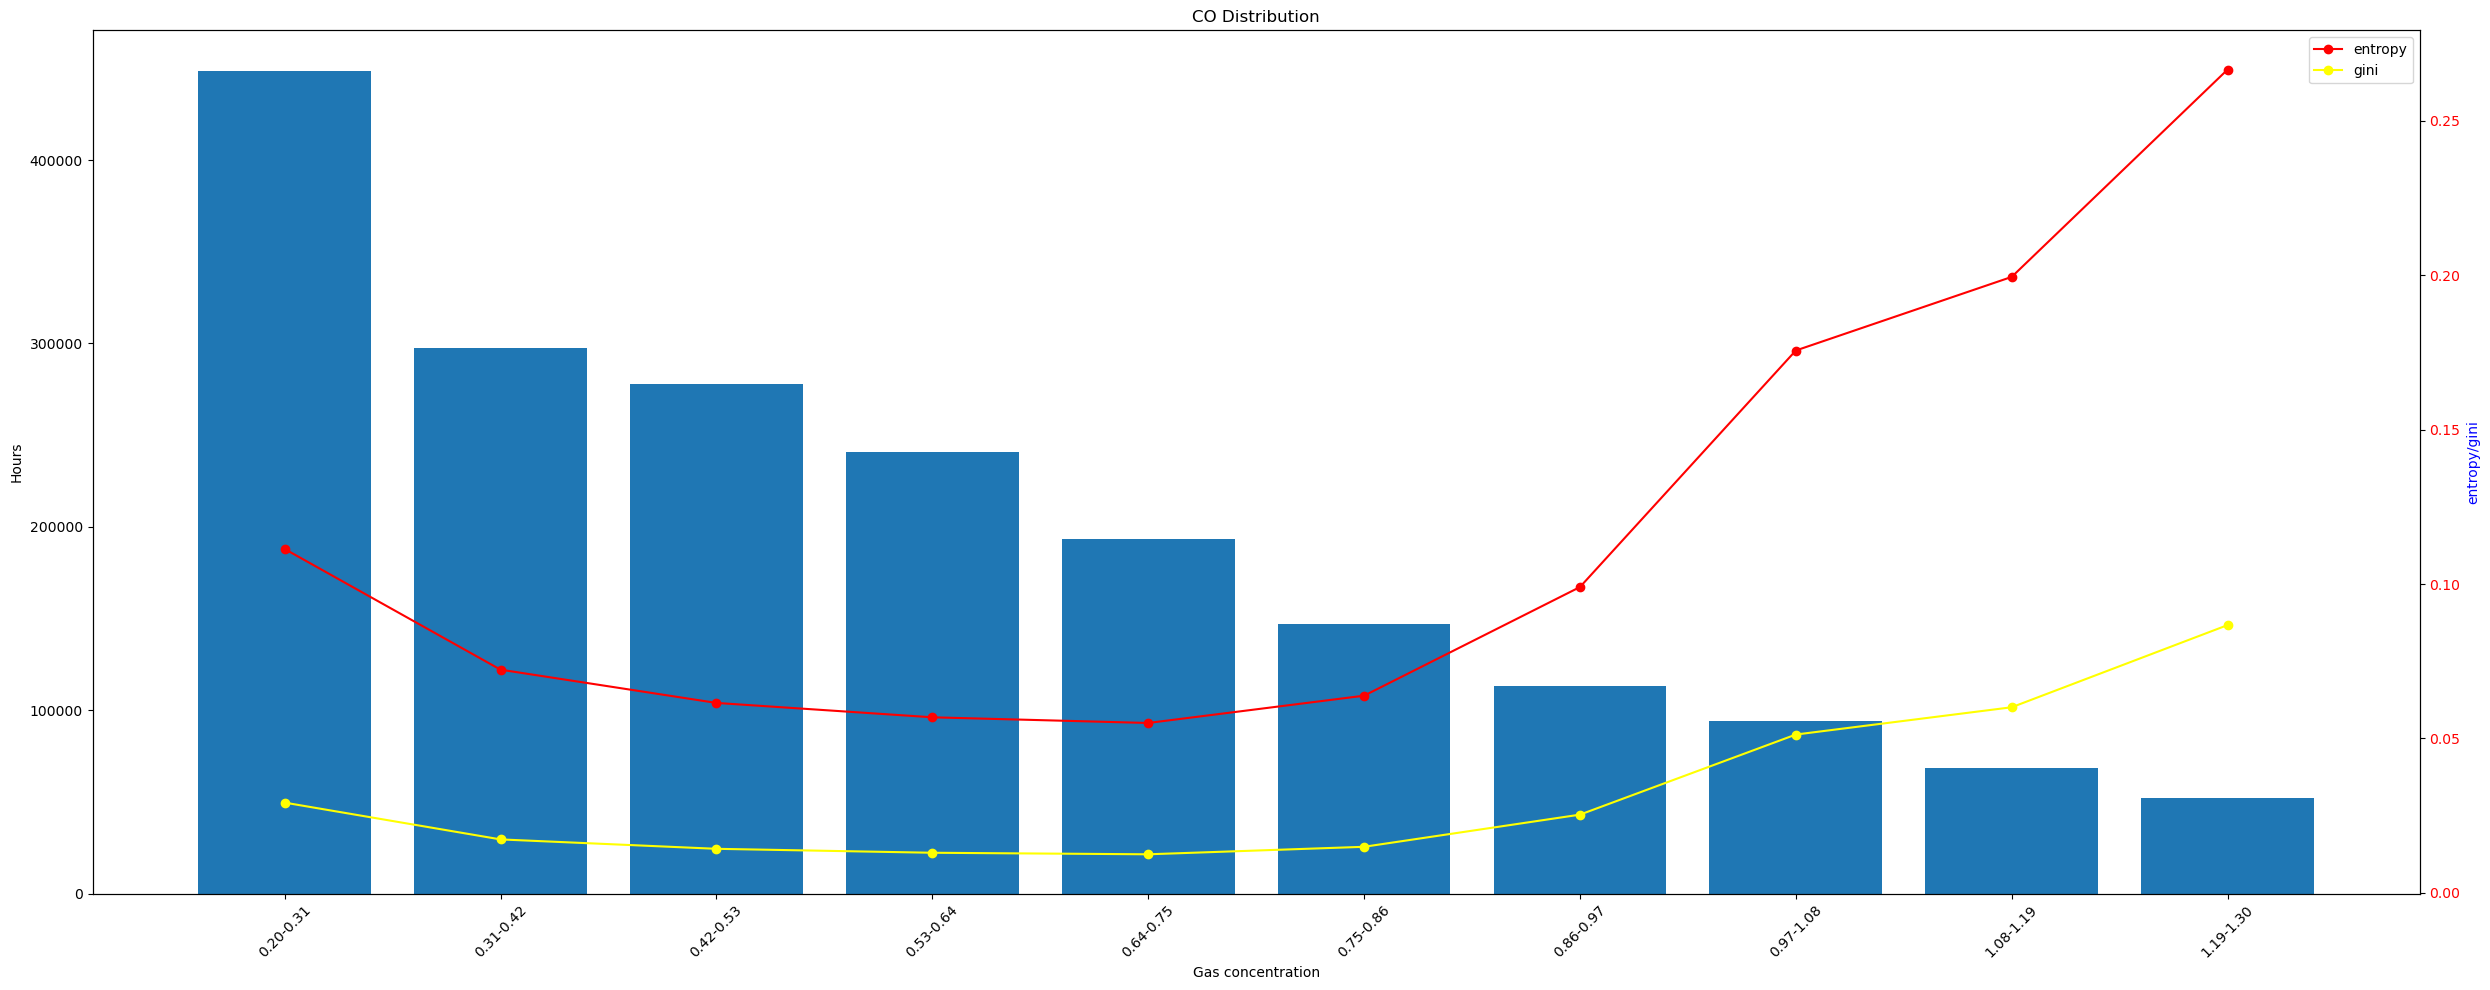

In [10]:
# CO
plot_data(original_X[:,5],y, gas_types[5],bin_count=10)

In [11]:
from scipy.stats import spearmanr

# ["PM2.5", "PM10", "SO2", "NO2", "O3", "CO"]
rho_PM25, p_value = spearmanr(original_X[:,0], y)
print("PM2.5 spearmanr is: ",rho_PM25)
rho_PM10, p_value = spearmanr(original_X[:,1], y)
print("PM10 spearmanr is: ",rho_PM10)
rho_SO2, p_value = spearmanr(original_X[:,2], y)
print("SO2 spearmanr is: ",rho_SO2)
rho_NO2, p_value = spearmanr(original_X[:,3], y)
print("NO2 spearmanr is: ",rho_NO2)
rho_O3, p_value = spearmanr(original_X[:,4], y)
print("O3 spearmanr is: ",rho_O3)
rho_CO, p_value = spearmanr(original_X[:,5], y)
print("CO spearmanr is: ",rho_CO)

PM2.5 spearmanr is:  0.2692209494117707
PM10 spearmanr is:  0.27693141731199694
SO2 spearmanr is:  0.1640407379462153
NO2 spearmanr is:  0.17366411536050946
O3 spearmanr is:  -0.10150638357021988
CO spearmanr is:  0.19292847397181026


In [12]:
# 归一化
def normalize_columns(data):
    # 计算每列的最小值和最大值 
    min_vals = data.min(axis=0) 
    max_vals = data.max(axis=0) 
    ranges = max_vals - min_vals 
    
    # 避免除以0的情况（若某列全相同，归一化后设为0）
    ranges[ranges == 0] = 1  
    
    # 归一化
    norm_data = (data - min_vals) / ranges 
    return norm_data

# test_data=np.array([[1,2,3],[2,2,2],[2,2,4]])
# normalize_columns(test_data)
X=normalize_columns(original_X)
print(X[1:3])

[[0.08808809 0.01230517 0.04008016 0.06412826 0.23275862 0.04522613]
 [0.06906907 0.00420427 0.02204409 0.0761523  0.22413793 0.04522613]]


In [13]:
# split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1954921, 6) (488731, 6) (1954921,) (488731,)


In [14]:
from sklearn.metrics  import accuracy_score, classification_report, confusion_matrix
def analysis_prediction(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion_mat=confusion_matrix(y_test, y_pred)
    
    print(f"accuracy: {accuracy:.2f}")
    print("\nclassification report:")
    print(report)
    print("\nconfusion_matrix:")
    print(confusion_mat)
    
    return accuracy, report, confusion_mat

In [15]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)

acc_LR, report_LR, confusion_matrix_LR = analysis_prediction(y_test, y_pred_LR)


accuracy: 0.98

classification report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    472175
         1.0       0.82      0.52      0.63     16556

    accuracy                           0.98    488731
   macro avg       0.90      0.76      0.81    488731
weighted avg       0.98      0.98      0.98    488731


confusion_matrix:
[[470328   1847]
 [  8004   8552]]


In [16]:
# desicion tree
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt=dt.predict(X_test)

acc_dt, report_dt, confusion_matrix_dt = analysis_prediction(y_test, y_pred_dt)

accuracy: 0.98

classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    472175
         1.0       0.70      0.71      0.71     16556

    accuracy                           0.98    488731
   macro avg       0.84      0.85      0.85    488731
weighted avg       0.98      0.98      0.98    488731


confusion_matrix:
[[467060   5115]
 [  4729  11827]]


In [17]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_pred_RF=RF.predict(X_test)

acc_RF, report_RF, confusion_matrix_RF = analysis_prediction(y_test, y_pred_RF)

accuracy: 0.99

classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    472175
         1.0       0.84      0.78      0.81     16556

    accuracy                           0.99    488731
   macro avg       0.92      0.89      0.90    488731
weighted avg       0.99      0.99      0.99    488731


confusion_matrix:
[[469704   2471]
 [  3654  12902]]


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
GBM = GradientBoostingClassifier()
GBM.fit(X_train, y_train)

y_pred_GBM=GBM.predict(X_test)

acc_GBM, report_GBM, confusion_matrix_GBM = analysis_prediction(y_test, y_pred_GBM)

accuracy: 0.99

classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    472175
         1.0       0.80      0.78      0.79     16556

    accuracy                           0.99    488731
   macro avg       0.90      0.89      0.89    488731
weighted avg       0.99      0.99      0.99    488731


confusion_matrix:
[[468955   3220]
 [  3648  12908]]


In [19]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

y_pred_KNN=KNN.predict(X_test)

acc_KNN, report_KNN, confusion_matrix_KNN = analysis_prediction(y_test, y_pred_KNN)

accuracy: 0.99

classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    472175
         1.0       0.82      0.73      0.77     16556

    accuracy                           0.99    488731
   macro avg       0.90      0.86      0.88    488731
weighted avg       0.98      0.99      0.98    488731


confusion_matrix:
[[469474   2701]
 [  4475  12081]]


In [20]:
from sklearn.neural_network import MLPClassifier
network = MLPClassifier(solver='adam', max_iter=1000)
network.fit(X_train, y_train)

y_pred_network=network.predict(X_test)

acc_network, report_network, confusion_matrix_network = analysis_prediction(y_test, y_pred_network)

accuracy: 0.98

classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    472175
         1.0       0.80      0.74      0.77     16556

    accuracy                           0.98    488731
   macro avg       0.90      0.87      0.88    488731
weighted avg       0.98      0.98      0.98    488731


confusion_matrix:
[[469131   3044]
 [  4352  12204]]
